## Pure Eigen and OpenMP experiment

This experiment is attempting to reproduce performance loss in singe core parts of Crocoddyl code with only OpenMp and Eigen. It checks how different ways of allocating memory and its flow in the code affect the performance.

The test checks how placement of matrices on heap vs stack can affect performance as well as how synchronization of memory between multi core and single core affects performance.

Variable `mem_sync` enables/disables synchronization of the memory between multi-core and single-core parts.
Variable `mem_type` changes internally used matrices between `Eigen::MatrixXd` and `Eigen::Matrix<double, K, K>`, where `K` is the size of the matrix.

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle
import time

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [46]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import subprocess

benchmark_path = "../../../build/experiments/pure_eigen_openmp/pure_eigen_openmp"
csv_path = "/tmp/bench.csv"

outputs = []
n_iter = 100

for i in tqdm(range(n_iter)):
    for access in ("raw", "pointers"):
        executable = benchmark_path + ("" if access == "raw" else "_pointers")
        for mem_sync in ("false", "true"):
            for mem_type in ("dynamic", "static"):
                for cores in range(1, 21):
                    subprocess.call(
                        [executable, str(cores), csv_path, mem_sync, mem_type]
                    )
                    df = pd.read_csv(csv_path)
                    df["access"] = access
                    outputs.append(df)

df = pd.concat(outputs)

time_str = time.strftime("%Y%m%d-%H%M")
with open(f"pure_eigen_openmp_{n_iter}_iter_{time_str}.pickle", "wb") as handle:
    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
with open("pure_eigen_openmp_100_iter_20241115-1232.pickle", "rb") as handle:
    df = pickle.load(handle)

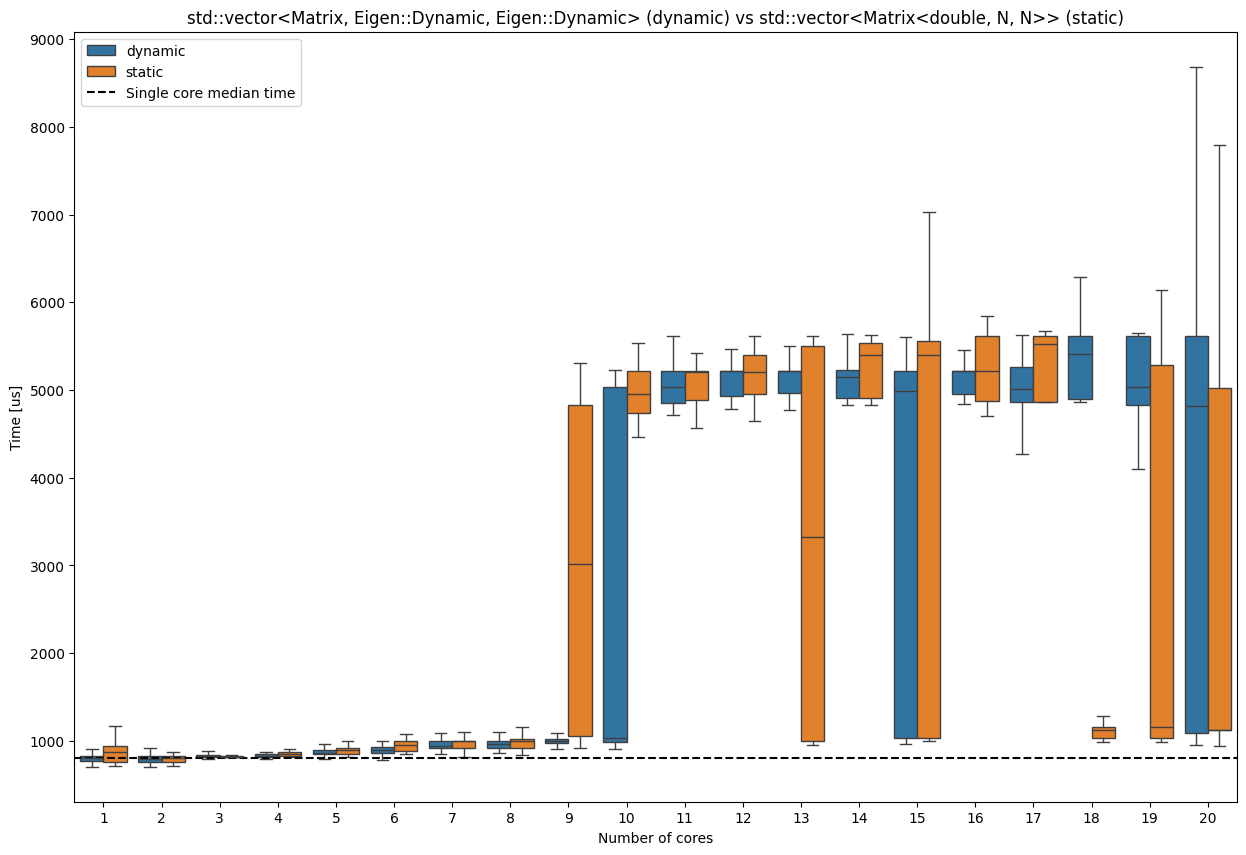

In [3]:
fig, axs = plt.subplots(1, 1, sharex=True)
fig.set_figheight(10)
fig.set_figwidth(15)

sync_mem = True
access_type = "raw"

sns.boxplot(
    data=df[(df["sync_mem"] == sync_mem) & (df["access"] == access_type)],
    x="nthreads",
    y="time",
    hue="alignment",
    showfliers=False,
    ax=axs,
)

df_base = df[df["nthreads"] == 1]
line = df_base[(df_base["sync_mem"] == sync_mem) & (df_base["sync_mem"] == sync_mem)][
    "time"
].median()
axs.axhline(y=line, color="k", linestyle="--", label="Single core median time")

axs.set(
    xlabel="Number of cores",
    ylabel="Time [us]",
    title="std::vector<Matrix, Eigen::Dynamic, Eigen::Dynamic> (dynamic) vs std::vector<Matrix<double, N, N>> (static)",
)

legend = axs.legend()

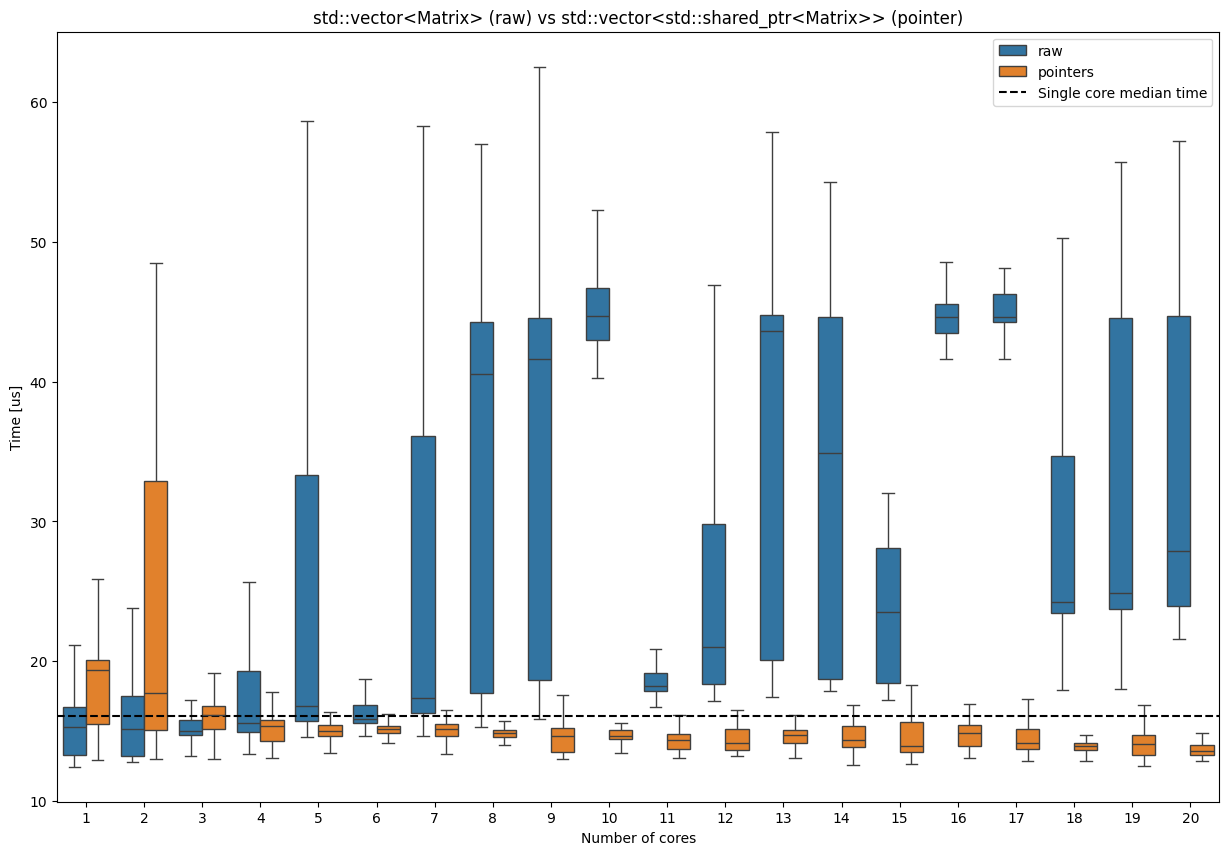

In [4]:
fig, axs = plt.subplots(1, 1, sharex=True)
fig.set_figheight(10)
fig.set_figwidth(15)

sync_mem = False
access_type = "raw"
alignment_type = "dynamic"

sns.boxplot(
    data=df[(df["sync_mem"] == sync_mem) & (df["alignment"] == alignment_type)],
    x="nthreads",
    y="time",
    hue="access",
    showfliers=False,
    ax=axs,
)

df_base = df[df["nthreads"] == 1]
line = df_base[
    (df_base["sync_mem"] == sync_mem) & (df_base["alignment"] == alignment_type)
]["time"].median()
axs.axhline(y=line, color="k", linestyle="--", label="Single core median time")

axs.set(
    xlabel="Number of cores",
    ylabel="Time [us]",
    title="std::vector<Matrix> (raw) vs std::vector<std::shared_ptr<Matrix>> (pointer)",
)

legend = axs.legend()